- Identify the Geospatial Attributes You Need: **shopping centre, schools, restaurants, public transportation, hospitals, beaches**


- Use the Overpass API with overpy2 Wrapper:

This will help you fetch data from OSM. You might need to learn the query language for the Overpass API, but there are plenty of examples online.



# Overview of the code
### 1.: Collecting 
### 2.: Provide a representative central point for each geographical feature type.
### 3.: Filters geospatial points inside Denmark, saves results, and reports exclusions.
### 4.: Combining the geospatial data into one file.

In [49]:
# pip install overpy


In [50]:
#pip install geopandas


### 1. This code uses the Overpass API to query OpenStreetMap for different types of locations (schools, restaurants, hospitals, malls), retrieves their nodes, ways, and relations, and organizes the data into dictionaries containing names and locations (longitude and latitude).

In [51]:
import overpy
import warnings
warnings.filterwarnings('ignore')

api = overpy.Overpass()

def query_osm(tag, value, bbox=(54.5, 8.0, 57.9, 15.2)):
    result = api.query(f"""
    [out:json];
    (
      node["{tag}"="{value}"]{bbox};
      way["{tag}"="{value}"]{bbox};
      relation["{tag}"="{value}"]{bbox};
    );
    (._;>;);
    out body;
    """)

    nodes = [{'name': item.tags.get('name', 'n/a'), 'location': (item.lon, item.lat)} for item in result.nodes]
    ways = [{'name': way.tags.get('name', 'n/a'), 'nodes': [(node.lon, node.lat) for node in way.nodes]} for way in result.ways]
    
    relations = []
    for relation in result.relations:
        relation_ways = [way for way in result.ways if way.id in [member.ref for member in relation.members if member.role == "outer"]]
        relations.append({'name': relation.tags.get('name', 'n/a'), 'ways': relation_ways})

    return nodes, ways, relations

schools_nodes, schools_ways, schools_relations = query_osm("amenity", "school")
restaurants_nodes, restaurants_ways, restaurants_relations = query_osm("amenity", "restaurant")
hospitals_nodes, hospitals_ways, hospitals_relations = query_osm("amenity", "hospital")
malls_nodes, malls_ways, malls_relations = query_osm("shop", "mall")


### 2. The resulting centroids of the below code provide a representative central point for each geographical feature type.

In [52]:
def calculate_centroid(nodes):
    lon_sum = sum([node[0] for node in nodes])
    lat_sum = sum([node[1] for node in nodes])
    centroid_lon = lon_sum / len(nodes)
    centroid_lat = lat_sum / len(nodes)
    return (centroid_lon, centroid_lat)

def collect_centroids(nodes, ways, relations):
    centroids = {}

    # Handle relations first:
    for relation in relations:
        name = relation['name']
        if name not in centroids:
            relation_centroids = [calculate_centroid([(node.lon, node.lat) for node in way.nodes]) for way in relation['ways'] if way.nodes]
            if relation_centroids:
                relation_centroid = calculate_centroid(relation_centroids)
                centroids[name] = relation_centroid

    # Then handle ways:
    for way in ways:
        name = way['name']
        if name not in centroids:
            if way['nodes']:
                way_centroid = calculate_centroid(way['nodes'])
                centroids[name] = way_centroid

    # Lastly, handle nodes:
    for node in nodes:
        name = node['name']
        if name not in centroids:
            centroids[name] = node['location']

    return centroids


schools_centroids = collect_centroids(schools_nodes, schools_ways, schools_relations)
restaurants_centroids = collect_centroids(restaurants_nodes, restaurants_ways, restaurants_relations)
hospitals_centroids = collect_centroids(hospitals_nodes, hospitals_ways, hospitals_relations)
malls_centroids = collect_centroids(malls_nodes, malls_ways, malls_relations)


In [53]:
import csv

all_centroids = {
    "Schools": schools_centroids,
    "Restaurants": restaurants_centroids,
    "Hospitals": hospitals_centroids,
    "Malls": malls_centroids,
}

# Write data to CSV with UTF-8 encoding
with open("2_all_centroids.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Latitude", "Longitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            if location != "No Centroid":
                writer.writerow([category, name, location[1], location[0]]) # Note: Swapped Lat and Long for your preference.
            else:
                writer.writerow([category, name, "No Centroid", "No Centroid"])

print("Data written to '2_all_centroids.csv'")


Data written to '2_all_centroids.csv'


### Now we want to collect data only inside Denmark. The below figure, is a plot of the area that we define as "Denmark" based on our "Danmark Shapefile" folder (this is just a check - not neccessary for our computation)

<Axes: >

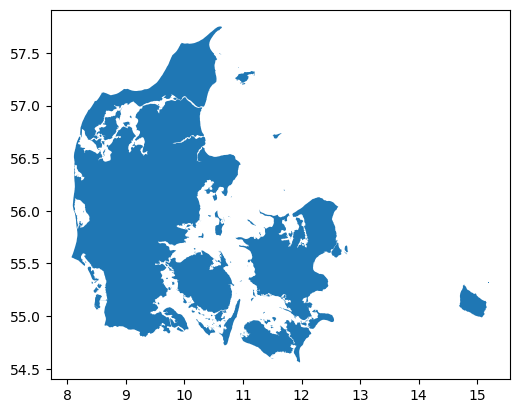

In [54]:
import geopandas as gpd

# Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("2_Danmark Shapefile/DNK_adm0.shp")

# Plot Denmark boundary
denmark_boundary.plot()

### 3. This code filters geospatial points inside Denmark, saves results, and reports exclusions.






In [55]:
import geopandas as gpd
import pandas as pd

# Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("2_Danmark Shapefile/DNK_adm0.shp")

# Load the CSV data
geo_df = pd.read_csv('2_all_centroids.csv')

# Convert the DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(geo_df.Longitude, geo_df.Latitude)
gdf_geo = gpd.GeoDataFrame(geo_df, geometry=geometry)

# Perform a spatial join to identify points within Denmark's boundary
geospatial_inside_denmark = gpd.sjoin(gdf_geo, denmark_boundary, op="within")

# Save the filtered data back to a new CSV
geospatial_inside_denmark.drop(columns=['geometry', 'index_right']).to_csv('2_geospatial_inside_denmark.csv', index=False)

print(f"{len(geo_df) - len(geospatial_inside_denmark)} data points were outside Denmark and have been removed.")


4947 data points were outside Denmark and have been removed.


### Now retreive only the first 4 columns

In [56]:
import geopandas as gpd
import pandas as pd

# Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("2_Danmark Shapefile/DNK_adm0.shp")

# Load the CSV data
geo_df = pd.read_csv('2_all_centroids.csv')

# Convert the DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(geo_df.Longitude, geo_df.Latitude)
gdf_geo = gpd.GeoDataFrame(geo_df, geometry=geometry)

# Perform a spatial join to identify points within Denmark's boundary
geospatial_inside_denmark = gpd.sjoin(gdf_geo, denmark_boundary, op="within")

# Select only the first 4 columns and save to a new CSV
columns_to_save = ["Type", "Name", "Latitude", "Longitude"]
geospatial_inside_denmark[columns_to_save].to_csv('2_geospatial_inside_denmark.csv', index=False)

print(f"{len(geo_df) - len(geospatial_inside_denmark)} data points were outside Denmark and have been removed.")


4947 data points were outside Denmark and have been removed.


 ### Public Transportation

In [57]:
import overpy

api = overpy.Overpass()

# Query for public transport stations in Denmark using the bounding box
result = api.query("""
[out:json];
(
  node["public_transport"="station"](54.5,8.0,57.9,15.2);
  way["public_transport"="station"](54.5,8.0,57.9,15.2);
  relation["public_transport"="station"](54.5,8.0,57.9,15.2);
);
(._;>;);
out body;
""")

# Structure the data
nodes = [{'name': station.tags.get('name', 'n/a'), 'location': (station.lon, station.lat)} for station in result.nodes]
ways = [{'name': way.tags.get('name', 'n/a'), 'nodes': [(node.lon, node.lat) for node in way.nodes]} for way in result.ways]

# For relations, fetch associated ways from the result
relations = []
for relation in result.relations:
    relation_ways = [way for way in result.ways if way.id in [member.ref for member in relation.members if member.role == "outer"]]
    relations.append({'name': relation.tags.get('name', 'n/a'), 'ways': relation_ways})


In [58]:
import csv

def get_centroid(nodes):
    """Calculate the centroid of a list of nodes."""
    x_coords = [node[0] for node in nodes]
    y_coords = [node[1] for node in nodes]
    centroid_x = sum(x_coords) / len(nodes)
    centroid_y = sum(y_coords) / len(nodes)
    return (centroid_x, centroid_y)

stations_centroids = {}

# Handle nodes:
for node in nodes:
    station_name = node['name']
    if station_name not in stations_centroids:
        stations_centroids[station_name] = node['location']

# Handle ways:
for way in ways:
    station_name = way['name']
    if station_name not in stations_centroids:
        stations_centroids[station_name] = get_centroid(way['nodes'])

# Handle relations:
for relation in relations:
    station_name = relation['name']
    if station_name not in stations_centroids:
        relation_centroids = [get_centroid([(node.lon, node.lat) for node in way.nodes]) for way in relation['ways']]
        stations_centroids[station_name] = get_centroid(relation_centroids)


In [59]:
import csv

# Combine all data
all_centroids = {
    "Public Transport Stations": stations_centroids,
}

# Write data to CSV with UTF-8 encoding
with open("2_public_transport_stations.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Longitude", "Latitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            if location != "No Centroid":
                writer.writerow([category, name, location[0], location[1]])
            else:
                writer.writerow([category, name, "No Centroid", "No Centroid"])

print("Data written to '2_public_transport_stations.csv'")


Data written to '2_public_transport_stations.csv'


In [60]:
import pandas as pd

# Assuming you've loaded your data into a DataFrame named 'df'
df = pd.read_csv('2_public_transport_stations.csv')

# Reordering the columns
df = df[['Type', 'Name', 'Latitude', 'Longitude']]

# Saving it back to the CSV (or to a new CSV if you prefer)
df.to_csv('2_public_transport_stations_right_order.csv', index=False)


In [61]:
import geopandas as gpd
import pandas as pd

# 1. Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("2_Danmark Shapefile/DNK_adm0.shp")

# 2. Load the CSV data
stations_df = pd.read_csv('2_public_transport_stations_right_order.csv')

# Convert the CSV dataframe to a geodataframe
gdf_stations = gpd.GeoDataFrame(stations_df,
                                geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude))

# 3. Perform spatial join to filter stations within Denmark's boundary
stations_inside_denmark = gpd.sjoin(gdf_stations, denmark_boundary, op="within")

# Select only the first 4 columns and save to a new CSV
columns_to_save = ["Type", "Name", "Latitude", "Longitude"]
stations_inside_denmark[columns_to_save].to_csv('2_stations_inside_denmark.csv', index=False)

print(f"{len(stations_df) - len(stations_inside_denmark)} data points were outside Denmark and have been removed.")

319 data points were outside Denmark and have been removed.


### Beaches


In [62]:
import overpy

api = overpy.Overpass()

# Query for beaches in Denmark using a more accurate bounding box
result = api.query("""
[out:json];
(
  node["natural"="beach"](54.5,8.0,57.9,15.2);
  way["natural"="beach"](54.5,8.0,57.9,15.2);
  relation["natural"="beach"](54.5,8.0,57.9,15.2);
);
(._;>;);
out body;
""")

# Structure the data
nodes = [{'name': beach.tags.get('name', 'n/a'), 'location': (beach.lon, beach.lat)} for beach in result.nodes]
ways = [{'name': way.tags.get('name', 'n/a'), 'nodes': [(node.lon, node.lat) for node in way.nodes]} for way in result.ways]

# For relations, fetch associated ways from the result
relations = []
for relation in result.relations:
    relation_ways = [way for way in result.ways if way.id in [member.ref for member in relation.members if member.role == "outer"]]
    relations.append({'name': relation.tags.get('name', 'n/a'), 'ways': relation_ways})


In [63]:
import csv

def get_centroid(nodes):
    """Calculate the centroid of a list of nodes."""
    x_coords = [node[0] for node in nodes]
    y_coords = [node[1] for node in nodes]
    centroid_x = sum(x_coords) / len(nodes)
    centroid_y = sum(y_coords) / len(nodes)
    return (centroid_x, centroid_y)

beaches_centroids = {}

# Handle nodes:
for node in nodes:
    beach_name = node['name']
    if beach_name not in beaches_centroids:
        beaches_centroids[beach_name] = node['location']

# Handle ways:
for way in ways:
    beach_name = way['name']
    if beach_name not in beaches_centroids:
        beaches_centroids[beach_name] = get_centroid(way['nodes'])

# Handle relations:
for relation in relations:
    beach_name = relation['name']
    if beach_name not in beaches_centroids:
        # For each way in the relation, retrieve its nodes and calculate its centroid
        relation_centroids = [get_centroid([(node.lon, node.lat) for node in way.nodes]) for way in relation['ways']]
        beaches_centroids[beach_name] = get_centroid(relation_centroids)

# Save to CSV
with open('2_Beaches.csv', 'w', newline='') as csvfile:
    fieldnames = ['Beach Name', 'Longitude', 'Latitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for name, location in beaches_centroids.items():
        writer.writerow({'Beach Name': name, 'Longitude': location[0], 'Latitude': location[1]})


In [64]:
import csv

# Combine all data
all_centroids = {
    "Beaches": beaches_centroids,
}

# Write data to CSV with UTF-8 encoding
with open("2_beaches.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Longitude", "Latitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            if location != "No Centroid":
                writer.writerow([category, name, location[0], location[1]])
            else:
                writer.writerow([category, name, "No Centroid", "No Centroid"])

print("Data written to '2_beaches.csv'")

Data written to '2_beaches.csv'


In [65]:
import pandas as pd

# Assuming you've loaded your data into a DataFrame named 'df'
df = pd.read_csv('2_Beaches.csv')

# Reordering the columns
df = df[['Type', 'Name', 'Latitude', 'Longitude']]

# Saving it back to the CSV (or to a new CSV if you prefer)
df.to_csv('2_Beaches_right_order.csv', index=False)

In [66]:
import geopandas as gpd
import pandas as pd

# 1. Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("2_Danmark Shapefile/DNK_adm0.shp")

# 2. Load the CSV data for the beaches
beaches_df = pd.read_csv('2_Beaches_right_order.csv')

# Convert the CSV dataframe to a geodataframe
gdf_beaches = gpd.GeoDataFrame(beaches_df, 
                               geometry=gpd.points_from_xy(beaches_df.Longitude, beaches_df.Latitude))

# 3. Check if each beach is within Denmark's boundary
# The resulting object is a Boolean Series
in_denmark = gdf_beaches.geometry.within(denmark_boundary.at[0, 'geometry'])

# 4. Filter the beaches that are inside Denmark's boundary
beaches_inside_denmark = gdf_beaches[in_denmark]

# 5. Save the filtered data back to a new CSV
beaches_inside_denmark.drop(columns='geometry').to_csv('2_beaches_inside_denmark.csv', index=False)

print(f"{len(beaches_df) - len(beaches_inside_denmark)} beaches were outside Denmark and have been removed.")

215 beaches were outside Denmark and have been removed.


### 4. Combining the Geospacial data:

In [67]:
# Load the data from the three CSV files into pandas DataFrames
stations_df = pd.read_csv("2_stations_inside_denmark.csv")
beaches_df = pd.read_csv("2_beaches_inside_denmark.csv")
geospatial_df = pd.read_csv("2_geospatial_inside_denmark.csv")

# Combine the three DataFrames into a single DataFrame
combined_df = pd.concat([stations_df, beaches_df, geospatial_df], ignore_index=True)

# Save the combined data to a new CSV file
combined_df.to_csv("2_Final_Geospatial_data.csv", index=False)

print("Data from the three CSV files has been successfully combined and saved to '2_Final_Geospatial_data.csv'.")

Data from the three CSV files has been successfully combined and saved to '2_Final_Geospatial_data.csv'.
